In [ ]:
# tile

# 1. Import libraireies

In [2]:
import numpy as np;
import pandas as pd;

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Modèles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

import joblib

# KIDNEY DESEASE DATASET

Ce dataset est utilisé pour **prédire la maladie rénale chronique `(CKD)`** en se basant sur différentes caractéristiques médicales. Il a été collecté en milieu hospitalier sur une période de **2 mois**.


In [3]:
class KIDNEY_DISEASE_DATASET():
    
    def __init__(self, path_file):
        self.path_file = path_file

    # Import Dataset
    def read_dataset(self):
        try:
            self.data = pd.read_csv(self.path_file)
            print("\nForme initiale du jeu de données:", self.data.shape)
            print("\nAfficher les premières lignes du dataset:")
            print(self.data.head())
            return self.data
        except FileNotFoundError:
            print(f"Fichier non trouvé: {self.path_file}")
            return None

    # Affichage des informations du dataset
    def data_infos(self, data,):

        # Suppression de la colonne 'id' si elle existe
        if 'id' in data.columns:
            data = data.drop('id', axis=1)

        print("\nInformation sur le dataset:")
        print(data.info())

        print("\nValeurs manquantes par colonne:")
        print(data.isnull().sum().sort_values(ascending=True))

        print("\nDescription des variables numériques du dataset:")
        print(data.describe())

        # # Renommage des colonnes pour plus de clarté
        # columns = ['age', 'blood_pressure', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
        #             'pus_cell_clumps', 'bacteria', 'blood_glucose_random', 'blood_urea', 'serum_creatinine', 'sodium',
        #             'potassium', 'haemoglobin', 'packed_cell_volume', 'white_blood_cell_count', 'red_blood_cell_count',
        #             'hypertension', 'diabetes_mellitus', 'coronary_artery_disease', 'appetite', 'peda_edema',
        #             'anaemia', 'class']
        
        # data.columns = columns
        # print("\nDataset avec les colonnes renommées:", data.shape)
        
        return data

    # Identification des colonnes numériques et catégoriques
    def check_numericals_and_categorials_columns(self, data):

        numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
        categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

        print("\nColonnes numériques:", numerical_cols)
        print("\nNombre de colonnes numériques:", len(numerical_cols))
        print("\nColonnes catégoriques:", categorical_cols)
        print("\nNombre colonnes catégoriques:", len(categorical_cols))
        

    # Vérification des valeurs uniques dans les variables catégoriques
    def check_unique_values_for_categorials(self, data):
        categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
        
        print("\nValeurs uniques dans les variables catégoriques:")
        for col in categorical_cols:
            print(f"\nColonne: {col}")
            print(data[col].unique())

    # Prétraitement des données
    def correct_incorrectly_encoded_columns(self, data):
        numerical_cols = data.select_dtypes(include=['number']).columns.tolist()
        categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

        # Correction des valeurs mal encodées
        columns_to_fix = ['pcv', 'wc', 'rc', 'dm', 'cad', 'classification']
        for col in columns_to_fix:
            if col in data.columns:
                data[col] = data[col].astype(str).str.strip().str.replace("\t", "").replace("?", np.nan)

        # Correction spécifique des valeurs dans certaines colonnes
        print("\nColonnes numériques:", numerical_cols)
        print("\nNombre de colonnes numériques:", len(numerical_cols))
        print("\nColonnes catégoriques:", categorical_cols)
        print("\nNombre de colonnes catégoriques:", len(categorical_cols))
        
        # Conversion des colonnes numériques mal encodées
        cols_to_convert = ['pcv', 'wc', 'rc']
        for col in cols_to_convert:
            if col in self.data.columns:
                data[col] = pd.to_numeric(data[col], errors='coerce')
        
        # Convertit toutes les colonnes non catégoriques (object) en float       
        data.select_dtypes(exclude = ['object']).columns
        for i in data.select_dtypes(exclude = ['object']).columns:
            data[i] = data[i].apply(lambda x: float(x))
        
        return data
    
    # Remplace les valeurs NaN par la valeur la plus fréquente (mode) dans chaque colonne.
    def Handling_Missing_Values(self, data):
        data_clean = self.correct_incorrectly_encoded_columns(data)
        mode = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
        df_clean = pd.DataFrame(mode.fit_transform(data_clean))
        df_clean.columns = data.columns
        
        return df_clean
    
    def encode_data(self, data):
        data_clean = self.Handling_Missing_Values(data)
        encode_data = data_clean.apply(preprocessing.LabelEncoder().fit_transform)
        
        return encode_data  
       
    # Heatmap correlation
    def correlation_columns(self, data):
        corr = data.corr()
        sns.heatmap(corr, annot = True, cmap='YlGnBu')
        plt.show()



In [4]:
# Charger les données

path_file = 'kidney_disease.csv'        
dataset = KIDNEY_DISEASE_DATASET(path_file)

data = dataset.read_dataset()



Forme initiale du jeu de données: (400, 26)

Afficher les premières lignes du dataset:
   id   age    bp     sg   al   su     rbc        pc         pcc          ba  \
0   0  48.0  80.0  1.020  1.0  0.0     NaN    normal  notpresent  notpresent   
1   1   7.0  50.0  1.020  4.0  0.0     NaN    normal  notpresent  notpresent   
2   2  62.0  80.0  1.010  2.0  3.0  normal    normal  notpresent  notpresent   
3   3  48.0  70.0  1.005  4.0  0.0  normal  abnormal     present  notpresent   
4   4  51.0  80.0  1.010  2.0  0.0  normal    normal  notpresent  notpresent   

   ...  pcv    wc   rc  htn   dm  cad appet   pe  ane classification  
0  ...   44  7800  5.2  yes  yes   no  good   no   no            ckd  
1  ...   38  6000  NaN   no   no   no  good   no   no            ckd  
2  ...   31  7500  NaN   no  yes   no  poor   no  yes            ckd  
3  ...   32  6700  3.9  yes   no   no  poor  yes  yes            ckd  
4  ...   35  7300  4.6   no   no   no  good   no   no            ckd  

[5 r

In [5]:
data.columns

Index(['id', 'age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr',
       'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

In [7]:
# Afficher les informations du dataset
data = dataset.data_infos(data)


Information sur le dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             391 non-null    float64
 1   bp              388 non-null    float64
 2   sg              353 non-null    float64
 3   al              354 non-null    float64
 4   su              351 non-null    float64
 5   rbc             248 non-null    object 
 6   pc              335 non-null    object 
 7   pcc             396 non-null    object 
 8   ba              396 non-null    object 
 9   bgr             356 non-null    float64
 10  bu              381 non-null    float64
 11  sc              383 non-null    float64
 12  sod             313 non-null    float64
 13  pot             312 non-null    float64
 14  hemo            348 non-null    float64
 15  pcv             330 non-null    object 
 16  wc              295 non-null    object 
 17  rc    

In [8]:
data.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wc', 'rc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'classification'],
      dtype='object')

## Format et dimensions des données **25 variables** 

- Le dataset initial contient **400 lignes** et **26 colonnes** avant suppression de la colonne `‘id’`.
- Après suppression de `‘id’`, le dataset est réduit à **25 colonnes**.
- **1 variable cible** : `class` (malade ou non malade).

## Types de Données & Valeurs Manquantes

- Certaines colonnes sont de type **float64**, tandis que d’autres sont **object** (probablement mal encodées ou catégoriques).
- Plusieurs colonnes présentent **un grand nombre de valeurs manquantes** :

| Variable | Nombre de valeurs manquantes | Pourcentage |
|----------|------------------------------|------------|
| `rbc` (Globules Rouges) | 152 / 400 | **38%** |
| `rc` (Numération GR) | 130 / 400 | **32.5%** |
| `wc` (Numération GB) | 105 / 400 | **26.25%** |
| `sod` (Sodium) | 87 / 400 | **21.75%** |

La **colonne cible** (`class`) ne contient **aucune valeur manquante**, ce qui est positif pour l’entraînement du modèle.

---

## Statistiques Descriptives

### **Analyse des Variables Numériques**
- Les variables numériques présentent **une forte dispersion** :
  - `age` varie entre **2 et 90 ans**.
  - `bp` (**Pression artérielle**) varie entre **50 et 180 mmHg** (valeurs extrêmes possibles).
  - `sc` (**Créatinine sérique**) va de **0.4 à 76.0 mg/dL** → **forte variabilité** (présence de valeurs aberrantes).
  - `pot` (**Potassium**) a un maximum de **47**, ce qui semble être **une erreur de saisie** (valeur normale : **3.5 - 5.5 mEq/L**).

---

In [164]:
# Identifier les variables numériques et catégoriques
dataset.check_numericals_and_categorials_columns(data)

## Variables Numériques (12)
| Variable | Description | Unité |
|----------|------------|-------|
| `id` | identifiant du patient | identifiant |
| `age` | Âge du patient | Années |
| `bp` | Pression artérielle | mmHg |
| `sg` | Gravité spécifique de l'urine | 1.005, 1.010, 1.015, 1.020, 1.025 |
| `al` | Présence d'albumine dans l'urine | 0, 1, 2, 3, 4, 5 |
| `su` | Présence de sucre dans l'urine | 0, 1, 2, 3, 4, 5 |
| `bgr` | Glycémie aléatoire | mg/dl |
| `bu` | Urée sanguine | mg/dl |
| `sc` | Créatinine sérique | mg/dl |
| `sod` | Sodium | mEq/L |
| `pot` | Potassium | mEq/L |
| `hemo` | Hémoglobine | g/dl |



## Variables Catégoriques (14)
| Variable | Description | Valeurs possibles |
|----------|------------|------------------|
| `rbc` | Globules rouges | normal, anormal |
| `pc` | Cellules de pus | normal, anormal |
| `pcc` | Amas de cellules de pus | présent, non présent |
| `ba` | Bactéries dans l'urine | présent, non présent |
| `pcv` | Volume cellulaire packé | % |
| `wc` | Numération des globules blancs | cellules/cumm |
| `rc` | Numération des globules rouges | millions/cmm |
| `htn` | Hypertension | oui, non |
| `dm` | Diabète | oui, non |
| `cad` | Maladie coronarienne | oui, non |
| `appet` | Appétit du patient | bon, mauvais |
| `pe` | Œdème pédieux (rétention d’eau) | oui, non |
| `ane` | Anémie | oui, non |
| **`classification`** | **Étiquette cible (CKD ou non CKD)** | **`ckd` (malade), `notckd` (non malade)** |


In [165]:
# Vérifier les valeurs uniques dans les variables catégoriques
dataset.check_unique_values_for_categorials(data)

## 3. Problèmes Identifiés

### **Valeurs aberrantes**: Certaines variables présentent des valeurs extrêmes qui nécessitent une vérification et un traitement :
- Présence de **valeurs extrêmes** dans les variables :
  - `sc` (créatinine sérique): Valeurs allant jusqu’à 76 mg/dL, ce qui semble trop élevé par rapport aux valeurs médicales standards.
  - `pot` (potassium): Maximum à 47 mEq/L, alors que la plage normale est généralement entre 3.5 et 5.5.
  - `bu` (urée sanguine): Valeurs allant jusqu’à 391 mg/dL, ce qui peut indiquer des erreurs de saisie ou des cas extrêmes.

### **Données mal encodées**
- Certaines colonnes catégoriques sont en **type `object`** alors qu’elles devraient être :
  - **Numériques** (`pcv`, `wc`, `rc`) : Ces colonnes contiennent des valeurs incorrectement encodées (ex : `'\t?'`, `'\t43'`).
  - **Catégoriques bien définies** :
    - `rbc`, `pc`, `pcc`, `ba`, `htn`, `dm`, `cad`, `appet`, `pe`, `ane`, `classification`
    - Présence de valeurs incohérentes (`' yes'`, `'\tno'`, `'ckd\t'` au lieu de ckd).



In [166]:
data_clean = dataset.Handling_Missing_Values(data)

In [167]:
#Exploring Unique Values in Columns

for i in data_clean.columns:
  print("*****************" , i ,"******************")
  print()
  print(set(data[i].tolist()))
  print()

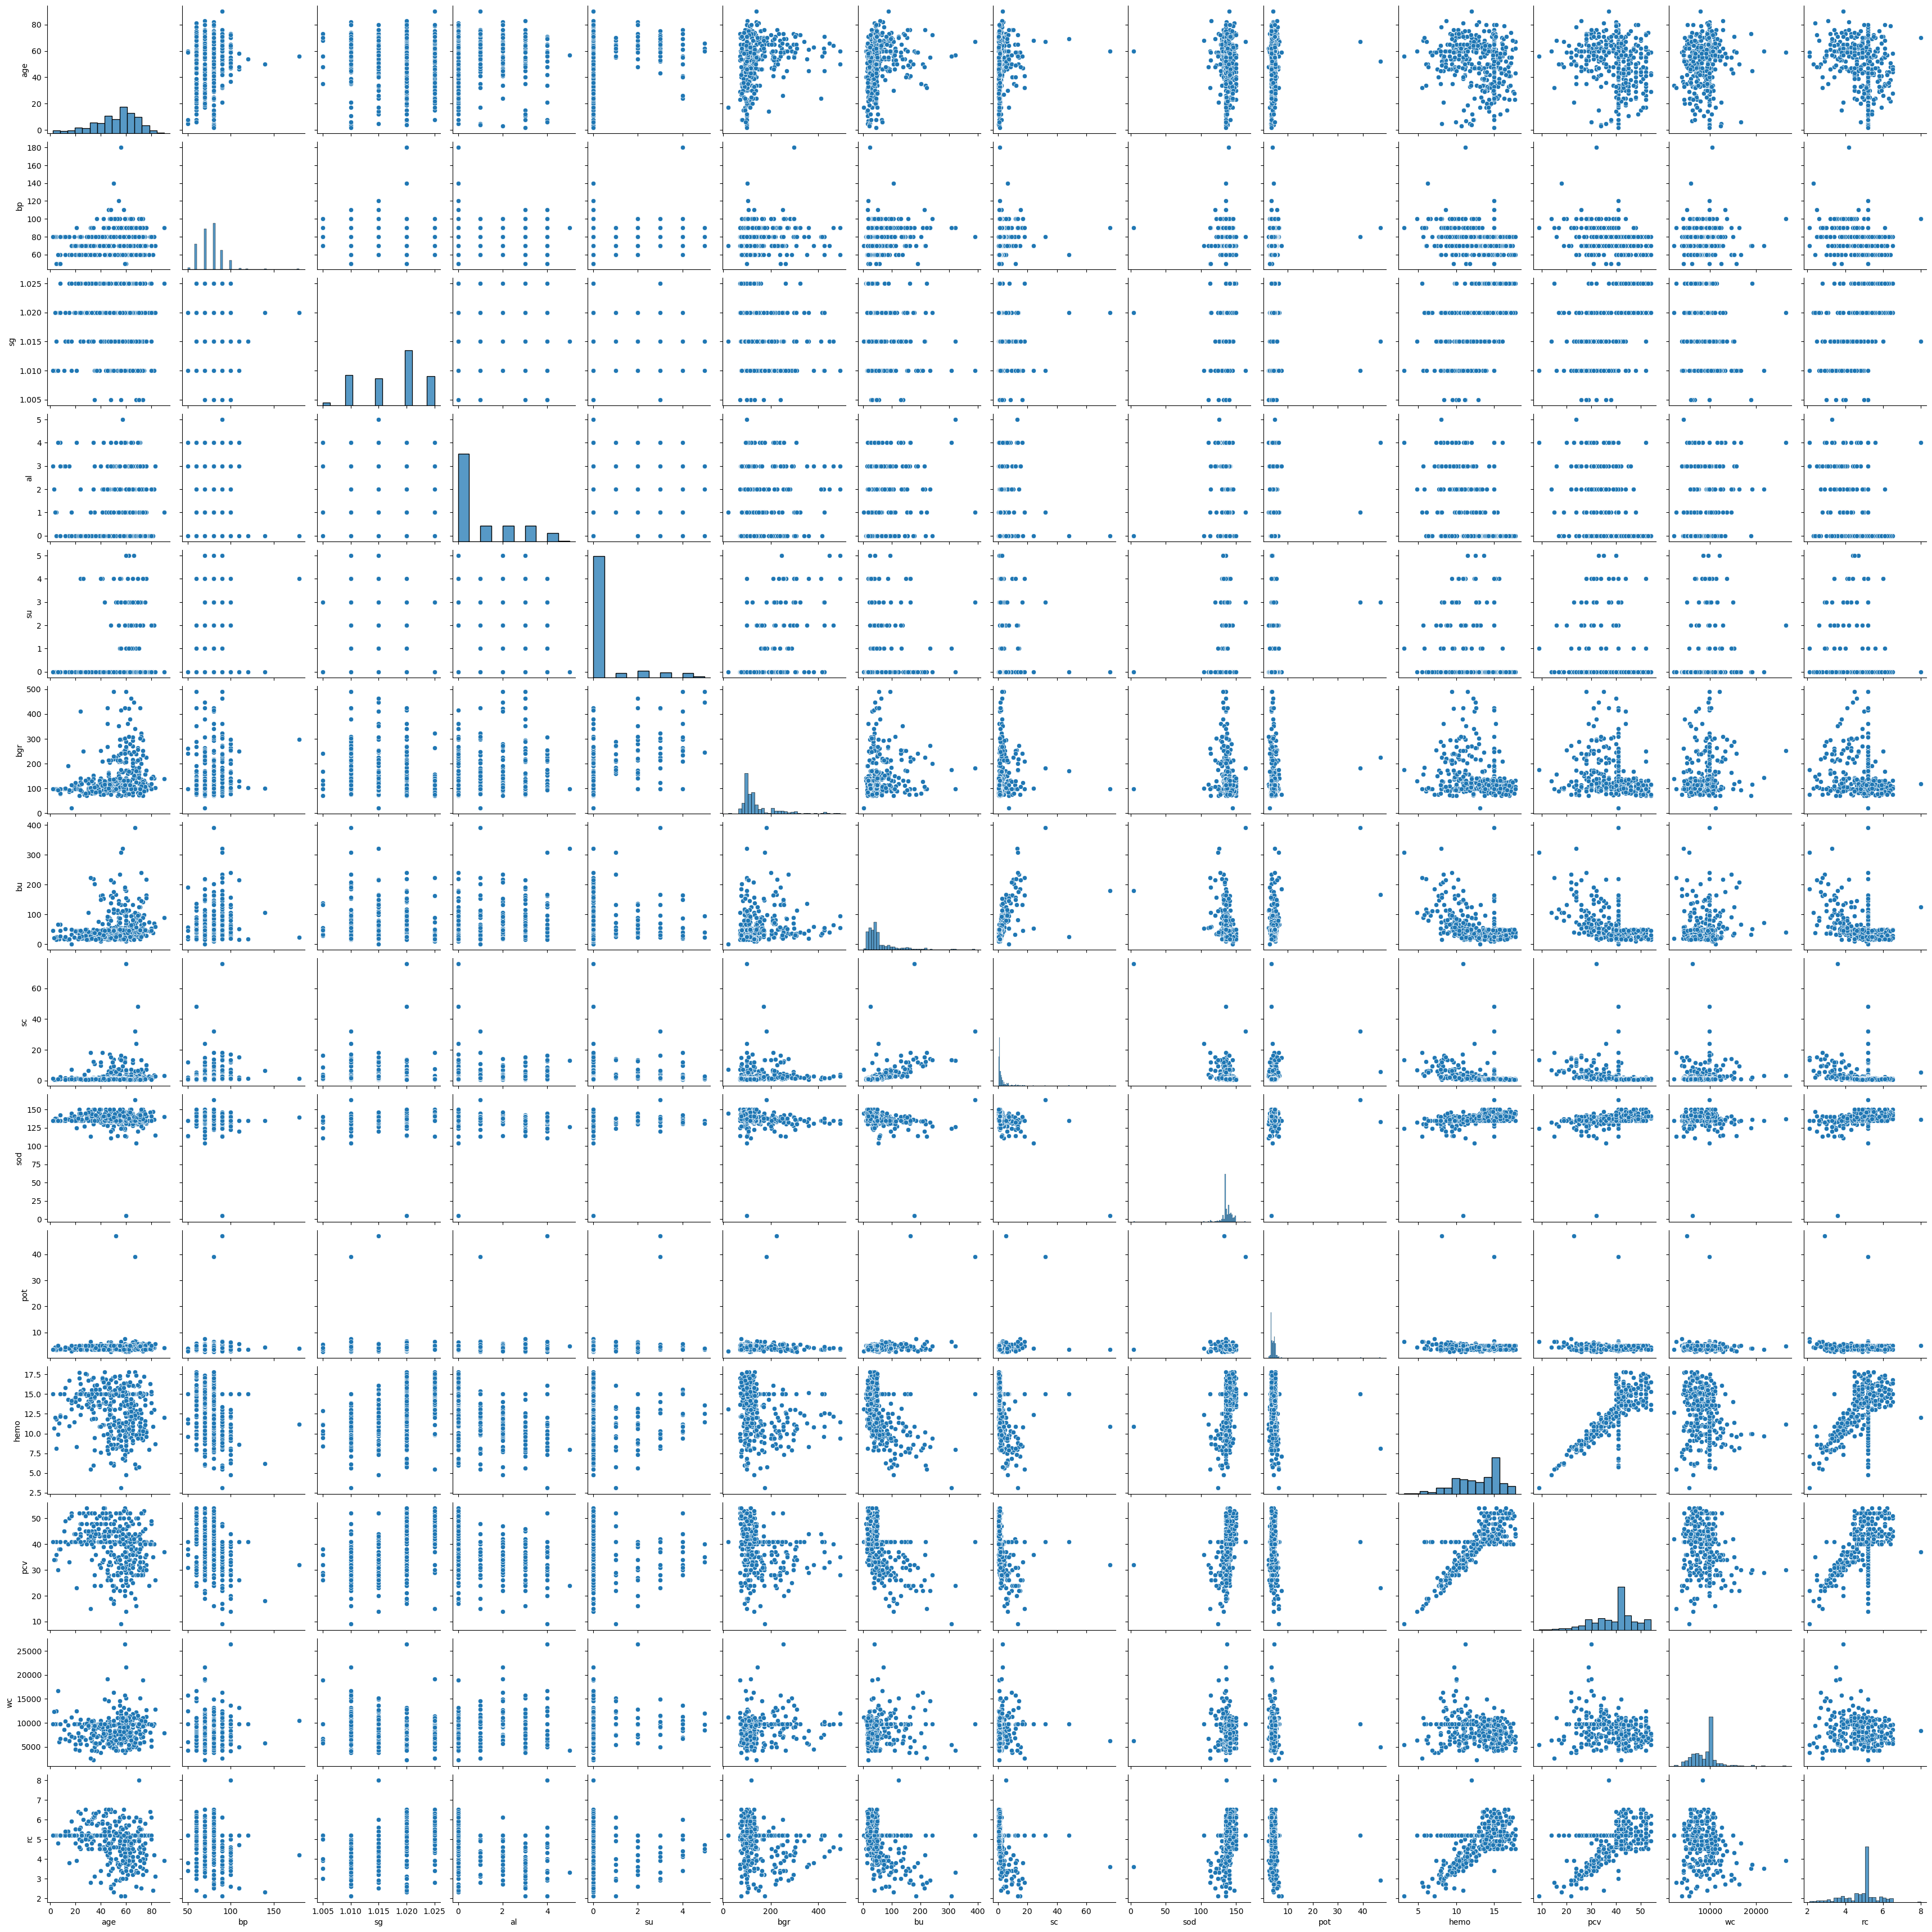

In [168]:
sns.pairplot(data_clean)

In [169]:
# Function to create distplot using Plotly Express
def distplot_plotly(col):
    fig = px.histogram(data, x=col, nbins=15, title=f'Distribution of {col}')
    fig.update_layout(
        plot_bgcolor='black',
        paper_bgcolor='black',
        font_color='white'
    )
    fig.show()

# Loop through numerical columns and create distplots
for col in data.select_dtypes(include='number').columns:
    distplot_plotly(col)

In [170]:
# Extracting categorical and numerical columns

cat_cols = [col for col in data_clean.columns if data_clean[col].dtype == 'object']
num_cols = [col for col in data_clean.columns if data_clean[col].dtype != 'object']

In [171]:
# outliers Detection & remove

num_cols1 = num_cols[:-2]
fig = px.box(data_clean[num_cols1], y=num_cols1)

fig.update_layout(
    plot_bgcolor='black',
    paper_bgcolor='black',
    font_color='white'
)
fig.show()

In [183]:
encode_data = dataset.encode_data(data)
encode_data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,40,3,3,1,0,1,1,0,0,48,...,31,35,30,1,2,1,0,0,0,0
1,5,0,3,4,0,1,1,0,0,26,...,25,19,30,0,1,1,0,0,0,0
2,54,3,1,2,3,1,1,0,0,140,...,18,33,30,0,2,1,1,0,1,0
3,40,2,0,4,0,1,0,1,0,44,...,19,25,17,1,1,1,1,1,1,0
4,43,3,1,2,0,1,1,0,0,33,...,22,31,24,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,47,3,3,0,0,1,1,0,0,64,...,34,25,27,0,1,1,0,0,0,1
396,34,2,4,0,0,1,1,0,0,3,...,41,35,40,0,1,1,0,0,0,1
397,8,3,3,0,0,1,1,0,0,27,...,36,24,32,0,1,1,0,0,0,1
398,11,1,4,0,0,1,1,0,0,41,...,38,30,37,0,1,1,0,0,0,1


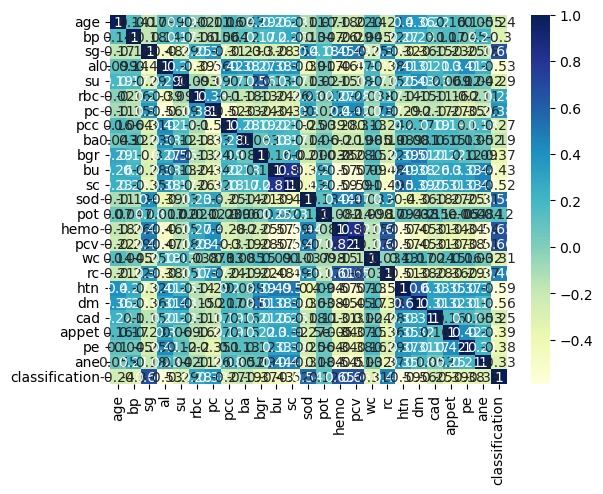

In [174]:
# correction datasets
dataset.correlation_columns(encode_data)

D’après la `matrice de corrélation`, nous observons que certaines caractéristiques présentent une `forte multicolinéarité` :
- `pcv` et `hemo` ont une corrélation de `82 %`, indiquant une redondance d’information.
- `sc` et `bu` ont une corrélation de `81 %` suggérant une forte interdépendance.
- 
Dans un modèle de Machine Learning, la présence de variables fortement corrélées peut entraîner des problèmes de multicolinéarité, ce qui peut affecter l’interprétation des coefficients et introduire du bruit dans les prédictions.

Pour réduire la multicolinéarité, nous supprimons une caractéristique dans chaque paire fortement corrélée :
- Suppression de `pcv`, car hemo semble mieux corrélé avec la variable cible classification (0.66).
- Suppression de `bu`, car sc a une corrélation plus forte avec classification (0.54 contre -0.43 pour bu).

In [184]:
encode_data.drop('pcv', axis=1, inplace=True)
encode_data.drop('bu', axis=1, inplace=True)
encode_data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,40,3,3,1,0,1,1,0,0,48,...,90,35,30,1,2,1,0,0,0,0
1,5,0,3,4,0,1,1,0,0,26,...,49,19,30,0,1,1,0,0,0,0
2,54,3,1,2,3,1,1,0,0,140,...,32,33,30,0,2,1,1,0,1,0
3,40,2,0,4,0,1,0,1,0,44,...,48,25,17,1,1,1,1,1,1,0
4,43,3,1,2,0,1,1,0,0,33,...,52,31,24,0,1,1,0,0,0,0


In [186]:
encode_data.to_csv("Final_pre_processing_data.csv")

In [178]:
# from IPython.display import display, HTML

# display(HTML("""
#     <div style="display: flex; justify-content: center; align-items: center; background: linear-gradient(45deg, #f58529, #dd2a7b, #8134af, #515bd4); padding: 20px; border-radius: 25px; position: relative;">
#         <h1 style="color: white; margin: 0;">
#             Model Building               📏📐          
#         </h1>
#     </div>
# """))

<div style="display: flex; justify-content: center; align-items: center; background: linear-gradient(45deg, #f58529, #dd2a7b, #8134af, #515bd4); padding: 20px; border-radius: 25px; position: relative;">
        <h1 style="color: white; margin: 0;">
            Model Building               📏📐          
        </h1>
    </div>

Nous construirons un modèle prédictif pour classer les cas d’IRC et évaluer ses performances.

In [214]:
class KidneyDiseaseModelTrainer():
    def __init__(self, file_path, target_col='classification'):
        """
        Initialisation de la classe avec chargement des données et prétraitement.
        """
        self.file_path = file_path
        self.target_col = target_col
        self.models = {
            "Decision Tree": DecisionTreeClassifier(),
            "Random Forest": RandomForestClassifier(),
            "SVM": SVC(),
            "Logistic Regression": LogisticRegression(),
            "KNN": KNeighborsClassifier(),
            "XGBoost": xgb.XGBClassifier()
        }
        self.results = {}

    def load_and_preprocess_data(self):
        """
        Charge et prétraite les données (équilibrage, normalisation, réduction de dimension).
        """
        # Charger les données
        data = pd.read_csv(self.file_path)
        
        print("colonnes:", data.columns)

        # Séparer les features et la cible
        X = data.drop(columns=[self.target_col])
        y = data[self.target_col]

        # Vérifier la répartition des classes avant équilibrage
        print("Répartition avant équilibrage :", Counter(y))

        # # Équilibrer les classes avec RandomOverSampler (éviter le sur-échantillonnage excessif)
        # ros = RandomOverSampler(sampling_strategy=0.75, random_state=42)  # Moins d'oversampling
        # X_ros, y_ros = ros.fit_resample(X, y)
        # print("Répartition après équilibrage :", Counter(y_ros))

        # Appliquer MinMaxScaler après équilibrage
        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_scaled = scaler.fit_transform(X)

        # Appliquer PCA (mais garder moins de dimensions pour éviter trop d'ajustement)
        # pca = PCA(n_components=0.90)  # Réduire à 90% de variance conservée
        # X_pca = pca.fit_transform(X_scaled)
        # print(f"Réduction de dimension : {X.shape[1]} -> {X_pca.shape[1]} composants")

        # Séparer en ensemble d'entraînement et de test AVANT l'équilibrage
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    def train_and_evaluate(self):
        """
        Entraîne plusieurs modèles et évalue leurs performances.
        """
        for model_name, model in self.models.items():
            print(f"\n🔹 Entraînement du modèle : {model_name}")

            # Entraînement du modèle
            model.fit(self.X_train, self.y_train)

            # Prédictions
            y_pred = model.predict(self.X_test)

            # Évaluation des performances
            accuracy = accuracy_score(self.y_test, y_pred)
            f1 = f1_score(self.y_test, y_pred, average='weighted')  # Calcul du F1-score
            conf_matrix = confusion_matrix(self.y_test, y_pred)
            class_report = classification_report(self.y_test, y_pred)

            # Stocker les résultats
            self.results[model_name] = {
                "accuracy": accuracy,
                "f1_score": f1,
                "confusion_matrix": conf_matrix,
                "classification_report": class_report
            }

            # Affichage des résultats
            print(f"✅ {model_name} - Accuracy: {accuracy:.4f} | F1-score: {f1:.4f}")
            print("\nMatrice de confusion :\n", conf_matrix)
            print("\nRapport de classification :\n", class_report)

    def compare_models(self):
        """
        Compare les modèles sur la base de l'accuracy et du f1_score.
        """
        accuracies = {model: res["accuracy"] for model, res in self.results.items()}
        f1_scores = {model: res["f1_score"] for model, res in self.results.items()}

        # Affichage des performances sous forme de graphique
        plt.figure(figsize=(12, 5))

        # Graphique des accuracy
        plt.subplot(1, 2, 1)
        sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette="Blues_r")
        plt.xlabel("Modèles")
        plt.ylabel("Accuracy")
        plt.title("Comparaison des modèles - Accuracy")
        plt.xticks(rotation=30)

        # Graphique des f1-scores
        plt.subplot(1, 2, 2)
        sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette="Greens_r")
        plt.xlabel("Modèles")
        plt.ylabel("F1-score")
        plt.title("Comparaison des modèles - F1 Score")
        plt.xticks(rotation=30)

        plt.tight_layout()
        plt.show()

    def get_best_model(self):
        """
        Retourne et sauvegarde le meilleur modèle en fonction de l'accuracy et du f1_score.
        """
        best_model = max(self.results, key=lambda k: self.results[k]["f1_score"])
        best_model_instance = self.models[best_model]

        print(f"\n🏆 Le meilleur modèle est : {best_model} avec une Accuracy de {self.results[best_model]['accuracy']:.4f} et un F1-score de {self.results[best_model]['f1_score']:.4f}")

        # Sauvegarde du meilleur modèle en .pkl
        model_filename = f"best_model_{best_model}.pkl"
        joblib.dump(best_model_instance, model_filename)
        print(f"📁 Modèle sauvegardé sous : {model_filename}")

        return best_model, best_model_instance

In [215]:
# Initialiser l'objet
model = KidneyDiseaseModelTrainer('Final_pre_processing_data.csv')

# Charger et prétraiter les données
model.load_and_preprocess_data()

In [216]:
# Entraîner et évaluer les modèles
model.train_and_evaluate()


/Users/habibmbow/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



/var/folders/d3/5nbyn1mn76d616kqs6f5t83m0000gn/T/ipykernel_29646/4255629796.py:137: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/d3/5nbyn1mn76d616kqs6f5t83m0000gn/T/ipykernel_29646/4255629796.py:145: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




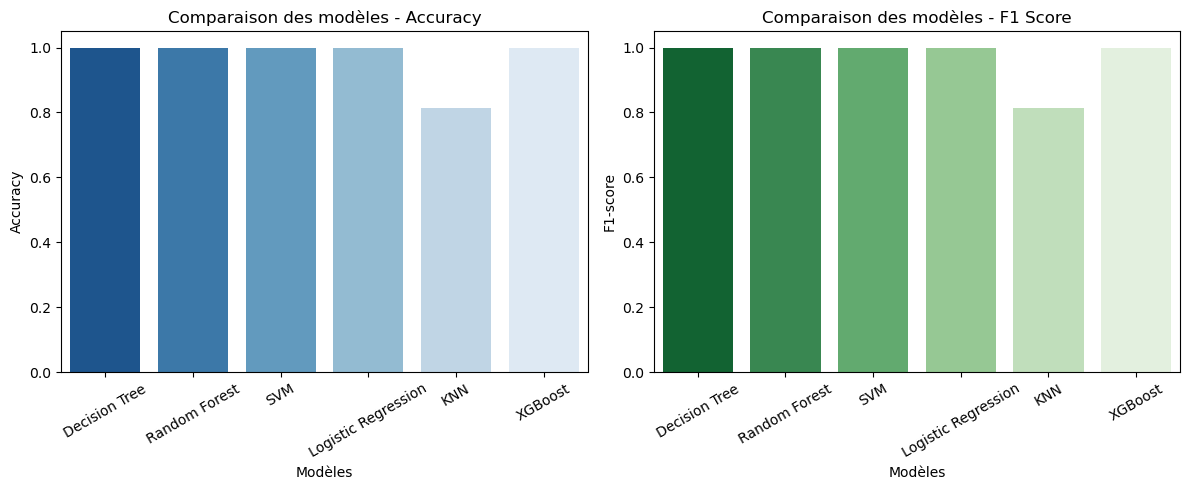

In [207]:

# Comparer les modèles
model.compare_models()


In [208]:

# Sélectionner le meilleur modèle
print("🏆 Meilleur modèle :")
best_model, best_model_instance = model.get_best_model()

In [129]:
import torch

if torch.backends.mps.is_available():
    print("MPS est disponible sur ce Mac")
else:
    print("MPS n'est pas disponible")